In [ ]:
import xgboost
import numpy as np
import shap

In [ ]:
! pip install SHAP

     |████████████████████████████████| 564 kB 5.0 MB/s 


In [ ]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
X[:,0:3] -= 0.5
y = 2*X[:,0] - 3*X[:,1]

In [ ]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 0.0
0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



In [ ]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

0.0

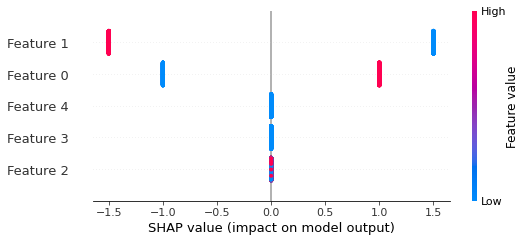

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
# train a linear model
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X, y)
lr_pred = lr.predict(X)
lr.coef_.round(2)

array([ 2., -3., -0.,  0.,  0.])

In [ ]:
# Make sure the computed SHAP values match the true SHAP values
# (we can compute the true SHAP values directly for this simple case)
main_effect_shap_values = lr.coef_ * (X - X.mean(0))
np.linalg.norm(shap_values - main_effect_shap_values)

1.6542433490447965e-13